## Biostat 257 Homework 2

In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)


In [2]:
#load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, Random

### Q1: Non-Negative Matrix Factorization

#### Q1.1 Develop Code

In [2]:
function nnmf(
    X        :: Matrix{T},
    r        :: Integer;
    maxiter  :: Integer = 1000,
    tolfun   :: Number = 1e-4,
    V        :: Matrix{T} = rand(T, size(X,1), r),
    W        :: Matrix{T} = rand(T, r, size(X,2)),
    ) where T <: AbstractFloat
    
    # initialization
   
    V = V 
    W = W 
    Z = Matrix(undef, size(X,1), size(X,2))
    
    # evaluate obj at starting point
    
    for j in 1:size(X,2), k in 1:r, i in 1:size(X,1)
        Z[i, j] = V[i, k] * W[k, j]
    end # multiplying VW and storing the results by columns
    
    obj = (norm(X-Z))^2
    niter = maxiter # initializing this variable
    
    #loop
     for iter in 1:maxiter
        
        #update V
          for i in 1:size(X,1), k in 1:10, j in 1:size(X,2)
            V[i, k] = V[i, k] * sum(X[i, j] * W[k, j])/sum((Z[i, j] * W[k, j]))
          end 
        
        # update Z with new V but with old W
           for j in 1:size(X,2), k in 1:r, i in 1:size(X,1)
            Z[i, j] = V[i, k] * W[k, j]
          end 
          
        # update W
        for i in 1:size(X,1), k in 1:10, j in 1:size(X,2)
            W[k, j] = W[k, j]* sum((X[i, j] * V[i, k]))/sum((Z[i, j] * V[i, k]))
        end
        
        # update Z
        
        Z[iter] = V*W # don't need to index by iter 
        
        # evaluate objective
        objold = obj
        obj = (norm(X-Z[iter]))^2
        
        # check convergence
        if abs(obj - objold) <= tolfun * (abs(objold) + 1)
            niter = iter 
            break # if converges we want to break out of the loop      
        end
        # output
        V, W, obj, niter
end
end

nnmf (generic function with 1 method)

In [19]:
# step 1: prototyping, make sure the algorithm works

function nnmf(
    X       :: Matrix{T}, 
    r       :: Integer;
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r),
    W       :: Matrix{T} = rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    n, m = size(X)
    obj = norm(X - V * W)^2
     mul!(storageR, transpose(V), V)
        mul!(storageW2, storageR, W)
        mul!(storageW1, transpose(V), X)
    if verbose
        println("iter=0, obj=$obj")
    end
    # implementation
    niter = maxiter
    storageR = Matrix{T}(undef, r, r)
    storageV1 = similar(V) # intermediate array for numerator of V
    storageV2 = similar(V) # intermediate array for denominator of V
    storageW1 = similar(W) # intermediate array for numerator of W
    storageW2 = similar(W) # intermediate array for denominator of W
    x2norm = norm(X)^2
    for iter in 1:maxiter
        # update V
        #V .= V .* (X * W') ./ (V * (W * W'))
        mul!(storageR, W, transpose(W)) # multiply WW' and store in storage R
        mul!(storageV2, V, storageR) 
        mul!(storageV1, X, transpose(W))
        V .= V .* storageV1 ./ storageV2
        
        # update W
        # W .= W .* (V' * X) ./ (V' * V * W)
        mul!(storageR, transpose(V), V)
        mul!(storageW2, storageR, W)
        mul!(storageW1, transpose(V), X)
        objold = obj
        obj = x2norm
        @inbounds for idx in eachindex(W)
            obj = obj + storageW2[idx] - 2storageW1[idx]) * W[idx]
            W[idx] = W[idx] * storagew1[idx] / storageW2[idx]
        end
        # check convergence
        if abs(obj - objold) <=  tolfun * (abs(objold) + 1)
            niter = iter
            break
        end
    # Output
    V, W, obj, niter
end 
end
# step 2: optimize code (lots of benchmarking, profiling, etc. to find out where the performance issue is, repeat.)

nnmf (generic function with 1 method)

#### Q1.2 Data

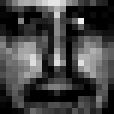

In [12]:
X = readdlm("nnmf-2429-by-361-face.txt") # each row is a face, goal: low rank approx of a face
colorview(Gray, reshape(X[1, :], 19, 19))

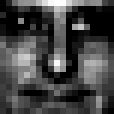

In [4]:
colorview(Gray, reshape(X[5, :], 19, 19))

#### Q1.3 Correctness and Efficiency

In [13]:
V0full = readdlm("V0.txt")
W0full = readdlm("W0.txt")

50×361 Matrix{Float64}:
 0.5634    0.32048   0.067202   0.25107   …  0.4476     0.12656   0.13688
 0.71473   0.25423   0.084735   0.84327      0.20947    0.32729   0.43787
 0.046351  0.041688  0.79152    0.8962       0.6786     0.17112   0.83691
 0.76991   0.13366   0.0061026  0.70588      0.4457     0.012722  0.64244
 0.56335   0.35408   0.62697    0.94923      0.073816   0.62934   0.58596
 0.13659   0.82449   0.17183    0.051802  …  0.87725    0.86247   0.45418
 0.2326    0.92296   0.73855    0.35246      0.015108   0.68424   0.15457
 0.95628   0.97221   0.94922    0.59106      0.49038    0.52232   0.4399
 0.82876   0.33257   0.95808    0.11028      0.66812    0.69979   0.57679
 0.33585   0.59454   0.75948    0.26544      0.34689    0.071471  0.020196
 0.87571   0.83349   0.83207    0.57283   …  0.34609    0.22545   0.2295
 0.27631   0.10171   0.4809     0.10614      0.0039955  0.92647   0.27393
 0.914     0.45783   0.32193    0.65607      0.1204     0.29447   0.88988
 ⋮             

In [20]:
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end

r=10


LoadError: MethodError: no method matching iterate(::Nothing)
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/range.jl:826
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/range.jl:826
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}} at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/dict.jl:695
[0m  ...

### Q2: Estimating Kinship Matrix

#### Q2.1 Develop code

In [ ]:
function kinship(G::Matrix{T}) where T <: AbstractFloat
    n, m = size(G)
    Φ = zeros(n, m)
    # output
    Φ
end